In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from scipy.linalg import svd, schur

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
import json
import copy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pygam import LinearGAM, s, l
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

In [4]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/misc_projects/pyfunc/')
from func import get_fdr_p_df, node_strength, ave_control, participation_coef, distance_bin
# from func import node_strength, ave_control, modal_control, rank_int, distance_bin, participation_coef

In [5]:
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
extra_str = '' # '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 200
parc_variant = 'orig' # 'orig' 'cortex_only'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight,
                                                                                       parc_variant = parc_variant)

In [6]:
os.environ['MODELDIR']

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount'

In [7]:
predictiondir = os.path.join(os.environ['MODELDIR'], 'predict_psy')
predictiondir

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount/predict_psy'

In [8]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

metrics = ['str', 'ac']
algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


## Setup plots

In [9]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
# sns.set(style='white', context = 'talk', font_scale = 0.75)
sns.set(style='white', context = 'paper', font_scale = 1)

cmap = sns.color_palette("pastel", 3)
os.environ['FIGDIR']

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount/figs'

## Load data

In [10]:
df_node = pd.read_csv(os.path.join(predictiondir, 'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc = pd.read_csv(os.path.join(predictiondir, 'X_ac_c.csv'))
df_node_ac_overc.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(predictiondir, 'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

c = pd.read_csv(os.path.join(predictiondir, 'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True); print(c.shape)
c.columns

(1068, 4)


Index(['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS'], dtype='object')

### Nuisance regression

In [11]:
# nuis_reg = LinearRegression(); nuis_reg.fit(c, df_node)
nuis_reg = KernelRidge(kernel='rbf'); nuis_reg.fit(c, df_node)
X_pred = nuis_reg.predict(c); df_node = df_node - X_pred

# nuis_reg = LinearRegression(); nuis_reg.fit(c, df_node_ac_overc)
# X_pred = nuis_reg.predict(c); df_node_ac_overc = df_node_ac_overc - X_pred

In [12]:
g = 0
gradient = np.loadtxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template.txt'))[:,g]

In [13]:
A = np.load(os.path.join(os.environ['MODELDIR'],'A_out.npy'))
A = np.mean(A, axis = 2)
np.any(np.isnan(A))

False

In [14]:
r_vals = pd.DataFrame(index = metrics, columns = phenos)
p_vals = pd.DataFrame(index = metrics, columns = phenos)

for metric in metrics:
    for pheno in phenos:
        X = df_node.filter(regex = metric).copy()
        y = df_pheno.loc[:,pheno].copy()
        
        X_y_corr = X.corrwith(y, method = 'spearman').values

        my_corr = sp.stats.spearmanr(gradient, X_y_corr)
        r_vals.loc[metric,pheno] = my_corr[0]
        p_vals.loc[metric,pheno] = my_corr[1]
        
p_vals = get_fdr_p_df(p_vals, rows = True)

In [15]:
r_vals

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg
str,-0.0810335,0.0306773,-0.0241911
ac,0.0660827,-0.302214,0.277343


In [16]:
r_vals[p_vals < .05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg
str,NaN,NaN,NaN
ac,NaN,-0.302214,0.277343


In [17]:
my_ac = ave_control(A)
my_str = node_strength(A)

my_ac = sp.stats.boxcox(my_ac)[0]
my_str = sp.stats.boxcox(my_str)[0]

# my_ac = rank_int(pd.Series(data = my_ac))
# my_str = rank_int(pd.Series(data = my_str))

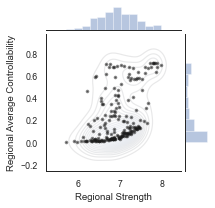

In [18]:
f = sns.jointplot(x = my_str, y = my_ac)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
# f.annotate(sp.stats.spearmanr)
f.plot_joint(sns.kdeplot, zorder = 0, n_levels = 20, alpha = 0.1)
f.plot_joint(plt.scatter, c = "k", s = 10, linewidth = 2, marker = ".", alpha = 0.5)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('Regional Strength')
f.ax_joint.set_ylabel('Regional Average Controllability')
f.savefig('regional_str_vs_ac.pdf', dpi = 300, bbox_inches = 'tight')

In [19]:
sp.stats.pearsonr(my_ac,my_str)

(0.4663590676186233, 3.40645877914501e-12)

In [20]:
sp.stats.spearmanr(my_ac,my_str)

SpearmanrResult(correlation=0.5318112952823821, pvalue=5.357370564549197e-16)

In [21]:
sp.stats.spearmanr(gradient,my_str)

SpearmanrResult(correlation=0.4868311707792696, pvalue=2.6829910675542726e-13)

In [22]:
sp.stats.spearmanr(gradient,my_ac)

SpearmanrResult(correlation=0.22569264231605793, pvalue=0.0013120462333603507)

In [23]:
if 'altcontrol' in os.environ['MODELDIR']:
    c_params = np.linspace(0.75, 0.25, 3)
#     c_params = np.linspace(0.25,0.99, 5)
#     c_params = np.round(c_params,1)
#     c_params[-1] = 0.99
else:
    c_params = np.array([10, 100, 1000, 10000])

c_params

array([   10,   100,  1000, 10000])

In [24]:
ac_orig_r = np.zeros(c_params.shape,)
ac_str_r = np.zeros(c_params.shape,)

for i, c_param in enumerate(c_params):
    ac_tmp = ave_control(A, c = c_param)
    ac_tmp = sp.stats.boxcox(ac_tmp)[0]
    
#     ac_orig_r[i] = sp.stats.pearsonr(my_ac,ac_tmp)[0]
#     ac_str_r[i] = sp.stats.pearsonr(my_str,ac_tmp)[0]
    ac_orig_r[i] = sp.stats.spearmanr(my_ac,ac_tmp)[0]
    ac_str_r[i] = sp.stats.spearmanr(my_str,ac_tmp)[0]

In [25]:
ac_orig_r[-1]

0.5376434410860272

In [26]:
ac_str_r[-1]

0.9250611265281633

Text(29.575000000000003, 0.5, 'corr(ac_orig,ac)')

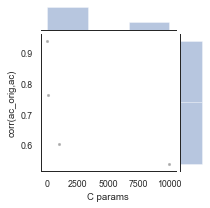

In [27]:
f = sns.jointplot(x = c_params, y = ac_orig_r)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
# f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('C params')
f.ax_joint.set_ylabel('corr(ac_orig,ac)')

Text(29.575000000000003, 0.5, 'corr(str,ac)')

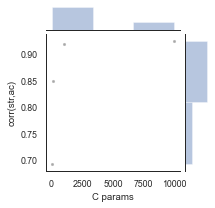

In [28]:
f = sns.jointplot(x = c_params, y = ac_str_r)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
# f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('C params')
f.ax_joint.set_ylabel('corr(str,ac)')

## Correlation between (ac,str) cross-subject similarity and gradient value

In [29]:
df_str = df_node.filter(regex = 'str')
df_ac = df_node.filter(regex = 'ac')
df_mc = df_node.filter(regex = 'mc')

ac_str_corr = df_str.corrwith(df_ac.set_axis(df_str.columns, axis='columns', inplace=False), method = 'pearson')
# ac_str_corr = df_ac.corrwith(df_str.set_axis(df_ac.columns, axis='columns', inplace=False), method = 'pearson')
# mc_str_corr = df_mc.corrwith(df_str.set_axis(df_mc.columns, axis='columns', inplace=False), method = 'pearson')

(-0.12, 0.12)

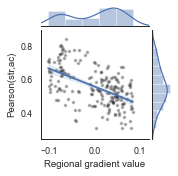

In [30]:
f = sns.jointplot(x = gradient, y = ac_str_corr, kind="reg")
f.fig.set_figwidth(2)
f.fig.set_figheight(2)
# f = sns.jointplot(x = gradient, y = mc_str_corr, kind="reg")
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 10, linewidth = 2, marker = ".", alpha = 0.3)

f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('Regional gradient value')
f.ax_joint.set_ylabel('Pearson(str,ac)')
f.ax_joint.set_ylim([0.25,0.9])
f.ax_joint.set_xlim([-0.12,0.12])
# f.savefig('regional_gradient_'+str(g)+'_vs_corr.svg', dpi = 300, bbox_inches = 'tight')

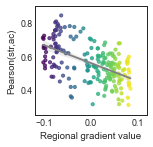

In [31]:
f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(2)
sns.regplot(x = gradient, y = ac_str_corr, color = 'gray', scatter = False)
plt.scatter(x = gradient, y = ac_str_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
ax.set_xlabel('Regional gradient value')
ax.set_ylabel('Pearson(str,ac)')
ax.set_ylim([0.25,0.9])
ax.set_xlim([-0.12,0.12])
ax.tick_params(pad = -2)
f.savefig('regional_gradient_'+str(g)+'_vs_corr.svg', dpi = 300, bbox_inches = 'tight')

In [32]:
ac_str_corr.mean()

0.5601916989567485

10
0.6384701595668355
(-0.4931257518890185, 1.1864515373006693e-13)
100
0.7168715298194357
(-0.4497797533943668, 2.3653749604018573e-11)
1000
0.7799420575527471
(-0.43659356168401314, 1.0271121899096776e-10)
10000
0.8534671892330452
(-0.3732040931464934, 5.2463097229503146e-08)


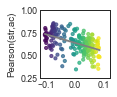

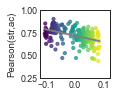

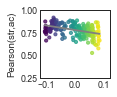

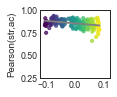

In [50]:
r_vals = np.zeros(len(c_params))

for i, c_param in enumerate(c_params):
    print(c_param)
    df_ac = df_node_ac_overc.filter(regex = 'ac_c'+str(c_param)+'_', axis = 1)
    ac_str_corr = df_str.corrwith(df_ac.set_axis(df_str.columns, axis='columns', inplace=False), method = 'pearson')
    print(ac_str_corr.mean())
    r_vals[i] = sp.stats.pearsonr(gradient,ac_str_corr)[0]
    print(sp.stats.pearsonr(gradient,ac_str_corr))

#     f = sns.jointplot(x = gradient, y = ac_str_corr, kind="reg")
#     f.fig.set_figwidth(1.25)
#     f.fig.set_figheight(1.25)
#     f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
#     f.ax_joint.collections[0].set_alpha(0)
#     f.ax_joint.set_xlabel('Regional Gradient Value')
#     f.ax_joint.set_ylabel('Pearson(ac,str)')
#     f.ax_joint.set_ylim([0.25,1])
#     f.ax_joint.set_xlim([-0.12,0.12])
#     f.savefig('regional_gradient_'+str(g)+'_vs_corr_c_'+str(c_param)+'.svg', dpi = 300, bbox_inches = 'tight')        

    f, ax = plt.subplots()
    f.set_figwidth(1.25)
    f.set_figheight(1.25)
    sns.regplot(x = gradient, y = ac_str_corr, color = 'gray', scatter = False)
    plt.scatter(x = gradient, y = ac_str_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
#     ax.set_xlabel('Regional gradient value')
    ax.set_xlabel('')
    ax.set_ylabel('Pearson(str,ac)')
    ax.set_ylim([0.25,1])
    ax.set_xlim([-0.12,0.12])
    ax.tick_params(pad = -2)
    f.savefig('regional_gradient_'+str(g)+'_vs_corr_c_'+str(c_param)+'.svg', dpi = 300, bbox_inches = 'tight')        
    
#     f = sns.jointplot(x = gradient, y = ac_str_corr, kind="reg", height = 3)
# #     f.annotate(sp.stats.pearsonr)
#     f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
#     f.ax_joint.collections[0].set_alpha(0)
#     f.ax_joint.set_xlabel('Regional gradient value')
#     f.ax_joint.set_ylabel('Pearson(str,ac)')
#     f.ax_joint.set_ylim([0.3,1])

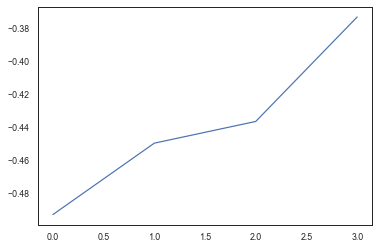

In [32]:
plt.plot(r_vals)

In [33]:
r_vals = pd.DataFrame(index = c_params, columns = phenos[1:])
p_vals = pd.DataFrame(index = c_params, columns = phenos[1:])

for c_param in c_params:
    for pheno in phenos[1:]:
        X = df_node_ac_overc.filter(regex = 'ac_c'+str(c_param)+'_').copy()
        y = df_pheno.loc[:,pheno].copy()
        
        X_y_corr = X.corrwith(y, method = 'spearman').values

        my_corr = sp.stats.spearmanr(gradient, X_y_corr)
        r_vals.loc[c_param,pheno] = my_corr[0]
        p_vals.loc[c_param,pheno] = my_corr[1]
        
p_vals = get_fdr_p_df(p_vals, rows = True)

In [34]:
r_vals

,Psychosis_Positive,Psychosis_NegativeDisorg
10,-0.202789,0.297402
100,-0.0729738,0.232194
1000,0.0169189,0.147251
10000,0.0304268,0.0924998


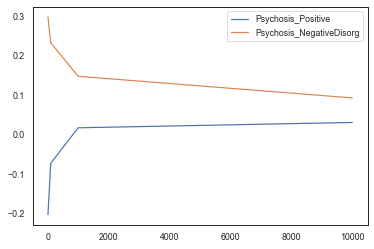

In [35]:
r_vals.plot()

### Sort data

In [36]:
sort_idx = np.argsort(gradient)
gradient_sorted = gradient[sort_idx]
A = A[sort_idx,:]
A = A[:,sort_idx]

In [37]:
# bin gradient
bin_size = 10
gradient_rank = sp.stats.rankdata(gradient).astype(int)
bins = np.arange(bin_size+1,num_parcels+bin_size+1,bin_size)
gradient_binned = np.digitize(gradient_rank, bins)

num_bins = int(num_parcels/bin_size); print(num_bins)
for i in np.arange(0,num_bins):
    print(i, gradient[gradient_binned == i].shape)

20
0 (10,)
1 (10,)
2 (10,)
3 (10,)
4 (10,)
5 (10,)
6 (10,)
7 (10,)
8 (10,)
9 (10,)
10 (10,)
11 (10,)
12 (10,)
13 (10,)
14 (10,)
15 (10,)
16 (10,)
17 (10,)
18 (10,)
19 (10,)


In [38]:
sns.set(style='white', context = 'talk', font_scale = 1)

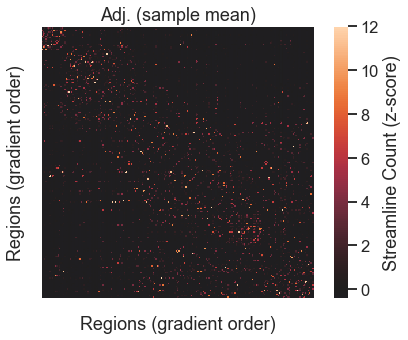

In [39]:
f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
sns.heatmap(sp.stats.zscore(A), center = 0, vmax = 12, ax = ax, square = True, cbar_kws={'label': 'Streamline Count (z-score)'})
ax.set_title('Adj. (sample mean)')
ax.set_xlabel('Regions (gradient order)')
ax.set_ylabel('Regions (gradient order)')
ax.set_xticklabels('')
ax.set_yticklabels('')
f.savefig('adj_sample_mean.pdf', dpi = 300, bbox_inches = 'tight')

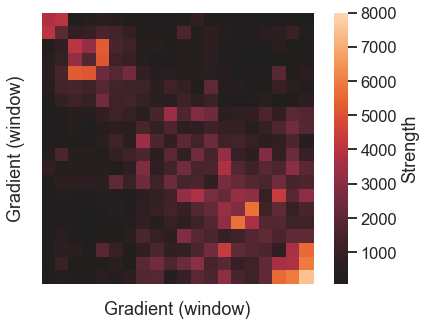

In [40]:
pairwise_bin_strength = np.zeros((num_bins,num_bins))

for i in np.arange(0,num_bins):
    mask_i = gradient_binned == i
    mask_i = mask_i[sort_idx]
    for j in np.arange(0,num_bins):
        mask_j = gradient_binned == j
        mask_j = mask_j[sort_idx]
        pairwise_bin_strength[i,j] = np.sum(A[np.ix_(mask_i,mask_j)])

plot_mask = pairwise_bin_strength == 0

# pairwise_bin_strength = (pairwise_bin_strength - pairwise_bin_strength.min()) / (pairwise_bin_strength.max() - pairwise_bin_strength.min())

f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
# sns.heatmap(pairwise_bin_strength, mask = plot_mask, center = 0, vmin = 500, ax = ax)
sns.heatmap(pairwise_bin_strength, center = 0, vmax = 8000, ax = ax, square = True, cbar_kws={'label': 'Strength'})
# ax.set_title('')
ax.set_xlabel('Gradient (window)')
ax.set_ylabel('Gradient (window)')
ax.set_xticklabels('')
ax.set_yticklabels('')
f.savefig('gradient_'+str(g)+'_window_stength.svg', dpi = 300, bbox_inches = 'tight')

Text(0, 0.5, 'Strength')

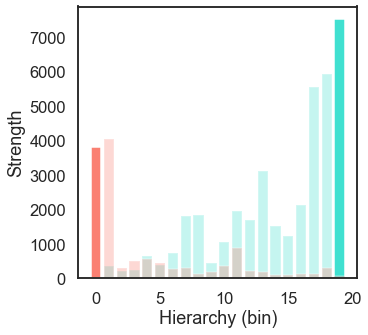

In [41]:
f, ax = plt.subplots()
f.set_figwidth(5)
f.set_figheight(5)
trans_ref = 1
uni_ref = 0

ax.bar(np.arange(0,num_bins), pairwise_bin_strength[-trans_ref,:], color = 'turquoise', alpha = 0.3)
ax.bar(num_bins-trans_ref, pairwise_bin_strength[-trans_ref,-trans_ref], color = 'turquoise')
ax.bar(np.arange(0,num_bins), pairwise_bin_strength[uni_ref,:], color = 'salmon', alpha = 0.3)
ax.bar(uni_ref, pairwise_bin_strength[uni_ref,uni_ref], color = 'salmon')
ax.set_xlabel('Hierarchy (bin)')
ax.set_ylabel('Strength')